## Практическая работа №6

1. В приложенном датасете собраны данные о результатах экзаменов студентов. Создайте из него числовой датасет.
2. Разделите полученный датасет на обучающую и тестовую часть в пропорции 70/30
3. Постройте три модели линейной регрессии для предсказания каждого из трех результатов экзаменов. Сделайте это в двух предположениях: 
     - результат экзамена не зависит от результатов уже прошедших экзаменов;
     - результат экзамена зависит от результатов уже прошедших экзаменов.
4. Вычислите R-квадрат для каждого предсказания.
5. Сделайте выводы о качестве прогноза соответственно предположениям.

In [1]:
# =============================================================================
# ИМПОРТ БИБЛИОТЕК И ЗАГРУЗКА ДАННЫХ
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Функция для загрузки данных из CSV файла
def load_exam_data(file_path):
    """
    Загружает данные об экзаменационных результатах из CSV файла
    
    Параметры:
    file_path - путь к файлу с данными
    
    Возвращает:
    Список словарей с исходными данными
    """
    data_records = []  # Список для хранения данных
    # Названия колонок для нашего датасета
    column_names = ["gender", "ethnicity", "parent_education", "lunch", "prep_course", "math", "reading", "writing"]
    
    # Открываем файл и читаем данные
    with open(file_path, 'r', encoding='utf-8') as file:
        headers = file.readline().strip().split(',')  # Читаем заголовки
        
        # Обрабатываем каждую строку данных
        for line in file:
            values = line.strip().split(',')  # Разбиваем строку на значения
            
            # Создаем запись с данными
            record = {
                column_names[0]: values[0],    # gender - пол
                column_names[1]: values[1],    # ethnicity - раса/этническая принадлежность  
                column_names[2]: values[2],    # parent_education - образование родителей
                column_names[3]: values[3],    # lunch - тип питания
                column_names[4]: values[4],    # prep_course - подготовительные курсы
                column_names[5]: int(values[5]),  # math - балл по математике
                column_names[6]: int(values[6]),  # reading - балл по чтению
                column_names[7]: int(values[7])   # writing - балл по письму
            }
            data_records.append(record)
    
    return data_records

# Загружаем исходные данные
raw_data = load_exam_data("exams - exams.csv")
print(f"Загружено записей: {len(raw_data)}")
print("Пример первой записи:", raw_data[0])

Загружено записей: 1000
Пример первой записи: {'gender': 'female', 'ethnicity': 'group D', 'parent_education': 'some college', 'lunch': 'standard', 'prep_course': 'completed', 'math': 59, 'reading': 70, 'writing': 78}


In [2]:
# =============================================================================
# ПРЕОБРАЗОВАНИЕ КАТЕГОРИАЛЬНЫХ ДАННЫХ В ЧИСЛОВЫЕ
# =============================================================================

# Словари для преобразования категориальных данных в числовые
conversion_maps = {
    "gender": {"female": 0, "male": 1},  # Пол: женский=0, мужской=1
    "ethnicity": {  # Этническая принадлежность: группы A-E
        "group A": 0, 
        "group B": 1, 
        "group C": 2, 
        "group D": 3, 
        "group E": 4
    },
    "parent_education": {  # Образование родителей
        "some high school": 0,      # Неоконченная средняя школа
        "high school": 1,           # Средняя школа
        "some college": 2,          # Неоконченный колледж
        "associate's degree": 3,    # Степень ассоциата
        "bachelor's degree": 4,     # Бакалавриат
        "master's degree": 5        # Магистратура
    },
    "lunch": {"standard": 0, "free/reduced": 1},  # Питание: стандартное=0, льготное=1
    "prep_course": {"none": 0, "completed": 1}    # Подготовка: не проходил=0, прошел=1
}

# Функция для преобразования категориальных данных в числовые
def convert_to_numeric(data):
    """
    Преобразует категориальные данные в числовые используя словари преобразования
    
    Параметры:
    data - исходные данные с категориальными признаками
    
    Возвращает:
    Данные с числовыми признаками
    """
    numeric_data = []
    
    for record in data:
        converted_record = {}
        # Преобразуем категориальные признаки используя словари
        converted_record["gender"] = conversion_maps["gender"][record["gender"]]
        converted_record["ethnicity"] = conversion_maps["ethnicity"][record["ethnicity"]]
        converted_record["parent_education"] = conversion_maps["parent_education"][record["parent_education"]]
        converted_record["lunch"] = conversion_maps["lunch"][record["lunch"]]
        converted_record["prep_course"] = conversion_maps["prep_course"][record["prep_course"]]
        # Числовые признаки (баллы) оставляем как есть
        converted_record["math"] = record["math"]
        converted_record["reading"] = record["reading"] 
        converted_record["writing"] = record["writing"]
        numeric_data.append(converted_record)
    
    return numeric_data

# Преобразуем данные
numeric_data = convert_to_numeric(raw_data)
print("Категориальные данные преобразованы в числовые")
print("Пример преобразованной записи:", numeric_data[0])

Категориальные данные преобразованы в числовые
Пример преобразованной записи: {'gender': 0, 'ethnicity': 3, 'parent_education': 2, 'lunch': 0, 'prep_course': 1, 'math': 59, 'reading': 70, 'writing': 78}


In [3]:
# =============================================================================
# НОРМАЛИЗАЦИЯ ДАННЫХ
# =============================================================================

# Функция для нормализации данных в диапазон [0, 1]
def normalize_data(data):
    """
    Нормализует данные в диапазон [0, 1] используя мин-макс нормализацию
    
    Параметры:
    data - данные для нормализации
    
    Возвращает:
    Нормализованные данные
    """
    # Собираем статистику по каждому признаку (мин и макс значения)
    stats = {}
    for key in data[0].keys():
        values = [item[key] for item in data]
        stats[key] = {
            'min': min(values),
            'max': max(values)
        }
    
    # Нормализуем данные
    normalized_data = []
    for record in data:
        normalized_record = {}
        for key, value in record.items():
            min_val = stats[key]['min']
            max_val = stats[key]['max']
            # Избегаем деления на ноль
            if max_val != min_val:
                normalized_record[key] = (value - min_val) / (max_val - min_val)
            else:
                normalized_record[key] = 0.5  # Если все значения одинаковы
        normalized_data.append(normalized_record)
    
    return normalized_data

# Нормализуем данные
normalized_data = normalize_data(numeric_data)
print("Данные нормализованы в диапазон [0, 1]")
print("Пример нормализованной записи:", normalized_data[0])

# Выводим статистику по нормализованным данным
print("\nСтатистика нормализованных данных:")
for key in normalized_data[0].keys():
    values = [item[key] for item in normalized_data]
    print(f"{key}: min={min(values):.4f}, max={max(values):.4f}, mean={np.mean(values):.4f}")

Данные нормализованы в диапазон [0, 1]
Пример нормализованной записи: {'gender': 0.0, 'ethnicity': 0.75, 'parent_education': 0.4, 'lunch': 0.0, 'prep_course': 1.0, 'math': 0.5176470588235295, 'reading': 0.6, 'writing': 0.7411764705882353}

Статистика нормализованных данных:
gender: min=0.0000, max=1.0000, mean=0.5080
ethnicity: min=0.0000, max=1.0000, mean=0.5467
parent_education: min=0.0000, max=1.0000, mean=0.4140
lunch: min=0.0000, max=1.0000, mean=0.3400
prep_course: min=0.0000, max=1.0000, mean=0.3440
math: min=0.0000, max=1.0000, mean=0.6213
reading: min=0.0000, max=1.0000, mean=0.6051
writing: min=0.0000, max=1.0000, mean=0.6369


In [4]:
# =============================================================================
# РАЗДЕЛЕНИЕ ДАННЫХ НА ОБУЧАЮЩУЮ И ТЕСТОВУЮ ВЫБОРКИ
# =============================================================================

# Разделяем данные в пропорции 70/30
split_index = int(len(normalized_data) * 0.7)
train_data = normalized_data[:split_index]
test_data = normalized_data[split_index:]

print(f"Общее количество записей: {len(normalized_data)}")
print(f"Обучающая выборка: {len(train_data)} записей ({len(train_data)/len(normalized_data)*100:.1f}%)")
print(f"Тестовая выборка: {len(test_data)} записей ({len(test_data)/len(normalized_data)*100:.1f}%)")

# Проверяем что разделение корректно
assert len(train_data) + len(test_data) == len(normalized_data), "Ошибка при разделении данных"
print("\nРазделение данных выполнено успешно")

Общее количество записей: 1000
Обучающая выборка: 700 записей (70.0%)
Тестовая выборка: 300 записей (30.0%)

Разделение данных выполнено успешно


In [5]:
# =============================================================================
# ОПРЕДЕЛЕНИЕ ФУНКЦИЙ ДЛЯ ЛИНЕЙНОЙ РЕГРЕССИИ
# =============================================================================

# Определяем наборы признаков для разных моделей
# Базовые признаки (демографические данные)
features_basic = ["gender", "ethnicity", "parent_education", "lunch", "prep_course"]
# Признаки для чтения (базовые + математика)
features_with_math = features_basic + ["math"]
# Признаки для письма (базовые + математика + чтение)
features_with_math_reading = features_basic + ["math", "reading"]

# Функция для линейной модели
def linear_model(inputs, coefficients):
    """
    Вычисляет предсказание линейной модели
    
    Параметры:
    inputs - входные признаки
    coefficients - коэффициенты модели (веса)
    
    Возвращает:
    Предсказанное значение
    """
    prediction = coefficients[0]  # Свободный член (intercept)
    # Добавляем взвешенную сумму признаков
    for i in range(len(inputs)):
        prediction += coefficients[i + 1] * inputs[i]
    return prediction

# Функция для вычисления среднеквадратичной ошибки
def calculate_error(dataset, coefficients, input_features, target_feature):
    """
    Вычисляет среднеквадратичную ошибку (MSE) модели
    
    Параметры:
    dataset - данные для вычисления ошибки
    coefficients - коэффициенты модели
    input_features - используемые признаки
    target_feature - целевая переменная
    
    Возвращает:
    Среднеквадратичную ошибку
    """
    total_error = 0.0
    for record in dataset:
        # Формируем входной вектор
        inputs = [record[feature] for feature in input_features]
        # Получаем предсказание
        predicted = linear_model(inputs, coefficients)
        # Фактическое значение
        actual = record[target_feature]
        # Суммируем квадрат ошибки
        total_error += (predicted - actual) ** 2
    
    # Возвращаем среднюю ошибку
    return total_error / len(dataset)

# Функция для вычисления градиента
def calculate_gradient(dataset, coefficients, input_features, target_feature):
    """
    Вычисляет градиент функции потерь
    
    Параметры:
    dataset - данные для вычисления градиента
    coefficients - текущие коэффициенты модели
    input_features - используемые признаки
    target_feature - целевая переменная
    
    Возвращает:
    Вектор градиента
    """
    num_coefficients = len(coefficients)
    gradient = [0.0] * num_coefficients
    
    for record in dataset:
        inputs = [record[feature] for feature in input_features]
        predicted = linear_model(inputs, coefficients)
        actual = record[target_feature]
        error = predicted - actual  # Ошибка предсказания
        
        # Градиент для свободного члена (производная по w0)
        gradient[0] += error
        
        # Градиенты для коэффициентов при признаках (производные по w1, w2, ...)
        for i in range(len(inputs)):
            gradient[i + 1] += error * inputs[i]
    
    # Усредняем градиент по всем примерам
    for i in range(num_coefficients):
        gradient[i] /= len(dataset)
        
    return gradient

# Функция градиентного спуска
def gradient_descent(dataset, initial_coefficients, input_features, target_feature, 
                   learning_rate=0.01, tolerance=1e-6, max_iterations=10000):
    """
    Выполняет градиентный спуск для обучения линейной регрессии
    
    Параметры:
    dataset - обучающие данные
    initial_coefficients - начальные коэффициенты
    input_features - используемые признаки
    target_feature - целевая переменная
    learning_rate - скорость обучения
    tolerance - точность для остановки
    max_iterations - максимальное число итераций
    
    Возвращает:
    Обученные коэффициенты и историю ошибок
    """
    coefficients = initial_coefficients.copy()
    error_history = []
    previous_error = float('inf')  # Начальное значение ошибки
    
    for iteration in range(max_iterations):
        # Вычисляем градиент
        grad = calculate_gradient(dataset, coefficients, input_features, target_feature)
        
        # Обновляем коэффициенты в направлении, противоположном градиенту
        for j in range(len(coefficients)):
            coefficients[j] -= learning_rate * grad[j]
        
        # Вычисляем текущую ошибку
        current_error = calculate_error(dataset, coefficients, input_features, target_feature)
        error_history.append(current_error)
        
        # Проверяем условие остановки (изменение ошибки меньше порога)
        if abs(previous_error - current_error) < tolerance:
            print(f"Обучение завершено на итерации {iteration}")
            break
            
        previous_error = current_error
    
    return coefficients, error_history

# Функция для обучения модели
def train_model(dataset, coefficients, features, target):
    """
    Обучает модель линейной регрессии
    
    Параметры:
    dataset - обучающие данные
    coefficients - начальные коэффициенты
    features - используемые признаки
    target - целевая переменная
    
    Возвращает:
    Обученные коэффициенты и историю ошибок
    """
    trained_coefficients, errors = gradient_descent(
        dataset, 
        coefficients, 
        features, 
        target,
        tolerance=0.0000001  # Точность остановки
    )
    return trained_coefficients, errors

print("Все функции для линейной регрессии определены")

Все функции для линейной регрессии определены


In [6]:
# =============================================================================
# ОБУЧЕНИЕ МОДЕЛЕЙ ДЛЯ ПЕРВОГО ПРЕДПОЛОЖЕНИЯ (НЕЗАВИСИМЫЕ ЭКЗАМЕНЫ)
# =============================================================================

print("ОБУЧЕНИЕ МОДЕЛЕЙ ДЛЯ ПЕРВОГО ПРЕДПОЛОЖЕНИЯ")
print("(экзамены не зависят от результатов уже прошедших экзаменов)")
print("=" * 70)

# Обучаем модели используя только базовые признаки (демографические данные)
print("\n1. МОДЕЛЬ ДЛЯ МАТЕМАТИКИ (только базовые признаки):")
math_coeffs_1, math_errors_1 = train_model(
    train_data, 
    [0.1] * (len(features_basic) + 1),  # Начальные коэффициенты
    features_basic,                      # Используемые признаки
    "math"                              # Целевая переменная
)
print(f"   Обученные коэффициенты: {[f'{c:.4f}' for c in math_coeffs_1]}")

print("\n2. МОДЕЛЬ ДЛЯ ЧТЕНИЯ (только базовые признаки):")
reading_coeffs_1, reading_errors_1 = train_model(
    train_data, 
    [0.1] * (len(features_basic) + 1), 
    features_basic, 
    "reading"
)
print(f"   Обученные коэффициенты: {[f'{c:.4f}' for c in reading_coeffs_1]}")

print("\n3. МОДЕЛЬ ДЛЯ ПИСЬМА (только базовые признаки):")
writing_coeffs_1, writing_errors_1 = train_model(
    train_data, 
    [0.1] * (len(features_basic) + 1), 
    features_basic, 
    "writing"
)
print(f"   Обученные коэффициенты: {[f'{c:.4f}' for c in writing_coeffs_1]}")

print("\nОбучение моделей для первого предположения завершено")

ОБУЧЕНИЕ МОДЕЛЕЙ ДЛЯ ПЕРВОГО ПРЕДПОЛОЖЕНИЯ
(экзамены не зависят от результатов уже прошедших экзаменов)

1. МОДЕЛЬ ДЛЯ МАТЕМАТИКИ (только базовые признаки):
Обучение завершено на итерации 3341
   Обученные коэффициенты: ['0.4691', '0.0713', '0.1659', '0.1037', '-0.1355', '0.0660']

2. МОДЕЛЬ ДЛЯ ЧТЕНИЯ (только базовые признаки):
Обучение завершено на итерации 3794
   Обученные коэффициенты: ['0.5282', '-0.0741', '0.1319', '0.0937', '-0.1007', '0.0957']

3. МОДЕЛЬ ДЛЯ ПИСЬМА (только базовые признаки):
Обучение завершено на итерации 3819
   Обученные коэффициенты: ['0.5507', '-0.0968', '0.1322', '0.1157', '-0.0969', '0.1272']

Обучение моделей для первого предположения завершено


In [7]:
# =============================================================================
# ОБУЧЕНИЕ МОДЕЛЕЙ ДЛЯ ВТОРОГО ПРЕДПОЛОЖЕНИЯ (ЗАВИСИМЫЕ ЭКЗАМЕНЫ)
# =============================================================================

print("ОБУЧЕНИЕ МОДЕЛЕЙ ДЛЯ ВТОРОГО ПРЕДПОЛОЖЕНИЯ")
print("(экзамены зависят от результатов уже прошедших экзаменов)")
print("=" * 70)

# Для математики используем только базовые признаки (первый экзамен)
print("\n1. МОДЕЛЬ ДЛЯ МАТЕМАТИКИ (только базовые признаки):")
math_coeffs_2, math_errors_2 = train_model(
    train_data, 
    [0.1] * (len(features_basic) + 1), 
    features_basic, 
    "math"
)
print(f"   Обученные коэффициенты: {[f'{c:.4f}' for c in math_coeffs_2]}")

# Для чтения используем базовые признаки + результат по математике
print("\n2. МОДЕЛЬ ДЛЯ ЧТЕНИЯ (базовые признаки + математика):")
reading_coeffs_2, reading_errors_2 = train_model(
    train_data, 
    [0.1] * (len(features_with_math) + 1), 
    features_with_math, 
    "reading"
)
print(f"   Обученные коэффициенты: {[f'{c:.4f}' for c in reading_coeffs_2]}")

# Для письма используем базовые признаки + математика + чтение
print("\n3. МОДЕЛЬ ДЛЯ ПИСЬМА (базовые признаки + математика + чтение):")
writing_coeffs_2, writing_errors_2 = train_model(
    train_data, 
    [0.1] * (len(features_with_math_reading) + 1), 
    features_with_math_reading, 
    "writing"
)
print(f"   Обученные коэффициенты: {[f'{c:.4f}' for c in writing_coeffs_2]}")

print("\nОбучение моделей для второго предположения завершено")

ОБУЧЕНИЕ МОДЕЛЕЙ ДЛЯ ВТОРОГО ПРЕДПОЛОЖЕНИЯ
(экзамены зависят от результатов уже прошедших экзаменов)

1. МОДЕЛЬ ДЛЯ МАТЕМАТИКИ (только базовые признаки):
Обучение завершено на итерации 3341
   Обученные коэффициенты: ['0.4691', '0.0713', '0.1659', '0.1037', '-0.1355', '0.0660']

2. МОДЕЛЬ ДЛЯ ЧТЕНИЯ (базовые признаки + математика):
   Обученные коэффициенты: ['0.1361', '-0.1372', '-0.0198', '-0.0004', '0.0125', '0.0377', '0.8589']

3. МОДЕЛЬ ДЛЯ ПИСЬМА (базовые признаки + математика + чтение):
Обучение завершено на итерации 5219
   Обученные коэффициенты: ['0.1531', '-0.0919', '0.0057', '0.0320', '-0.0065', '0.0588', '0.3570', '0.4553']

Обучение моделей для второго предположения завершено


In [8]:
# =============================================================================
# ФУНКЦИИ ДЛЯ ОЦЕНКИ КАЧЕСТВА МОДЕЛЕЙ
# =============================================================================

# Функция для создания предсказаний на тестовой выборке
def make_predictions(dataset, coefficients, input_features, target_feature):
    """
    Создает предсказания для набора данных
    
    Параметры:
    dataset - данные для предсказания
    coefficients - обученные коэффициенты модели
    input_features - используемые признаки
    target_feature - целевая переменная
    
    Возвращает:
    Фактические значения и предсказания
    """
    predictions = []
    actual_values = []
    
    for record in dataset:
        # Формируем входной вектор
        inputs = [record[feature] for feature in input_features]
        # Получаем предсказание
        pred = linear_model(inputs, coefficients)
        predictions.append(pred)
        # Сохраняем фактическое значение
        actual_values.append(record[target_feature])
    
    return actual_values, predictions

# Функция для вычисления коэффициента детерминации R²
def calculate_r_squared(actual, predicted):
    """
    Вычисляет коэффициент детерминации R²
    
    Параметры:
    actual - фактические значения
    predicted - предсказанные значения
    
    Возвращает:
    Коэффициент детерминации R²
    """
    # Среднее значение фактических данных
    mean_actual = sum(actual) / len(actual)
    
    # Сумма квадратов остатков (объясненная моделью вариация)
    ss_residual = sum((actual[i] - predicted[i]) ** 2 for i in range(len(actual)))
    # Общая сумма квадратов (общая вариация)
    ss_total = sum((actual[i] - mean_actual) ** 2 for i in range(len(actual)))
    
    # Избегаем деления на ноль
    if ss_total == 0:
        return 0
    
    # R² = 1 - (необъясненная вариация) / (общая вариация)
    r_squared = 1 - (ss_residual / ss_total)
    return r_squared

# Функция для визуализации результатов
def visualize_predictions(actual, predicted, errors, title):
    """
    Визуализирует предсказания и процесс обучения
    
    Параметры:
    actual - фактические значения
    predicted - предсказанные значения  
    errors - история ошибок обучения
    title - заголовок графика
    """
    # Создаем фигуру с двумя подграфиками
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Левый график: предсказания vs фактические значения
    ax1.scatter(actual, predicted, alpha=0.6, color='blue')
    # Диагональная линия (идеальные предсказания)
    min_val = min(min(actual), min(predicted))
    max_val = max(max(actual), max(predicted))
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)
    ax1.set_xlabel('Фактические значения')
    ax1.set_ylabel('Предсказанные значения')
    # Вычисляем R² для заголовка
    r_squared = calculate_r_squared(actual, predicted)
    ax1.set_title(f'{title}\nR² = {r_squared:.4f}')
    ax1.grid(True, alpha=0.3)
    
    # Правый график: история обучения (ошибка по итерациям)
    ax2.plot(errors, color='green')
    ax2.set_yscale('log')  # Логарифмическая шкала для лучшей визуализации
    ax2.set_xlabel('Номер итерации')
    ax2.set_ylabel('Ошибка (лог масштаб)')
    ax2.set_title('История обучения модели')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return r_squared

print("Функции для оценки качества моделей определены")

Функции для оценки качества моделей определены


ОЦЕНКА МОДЕЛЕЙ ПЕРВОГО ПРЕДПОЛОЖЕНИЯ
(экзамены не зависят от результатов уже прошедших экзаменов)

1. МОДЕЛЬ ДЛЯ МАТЕМАТИКИ:


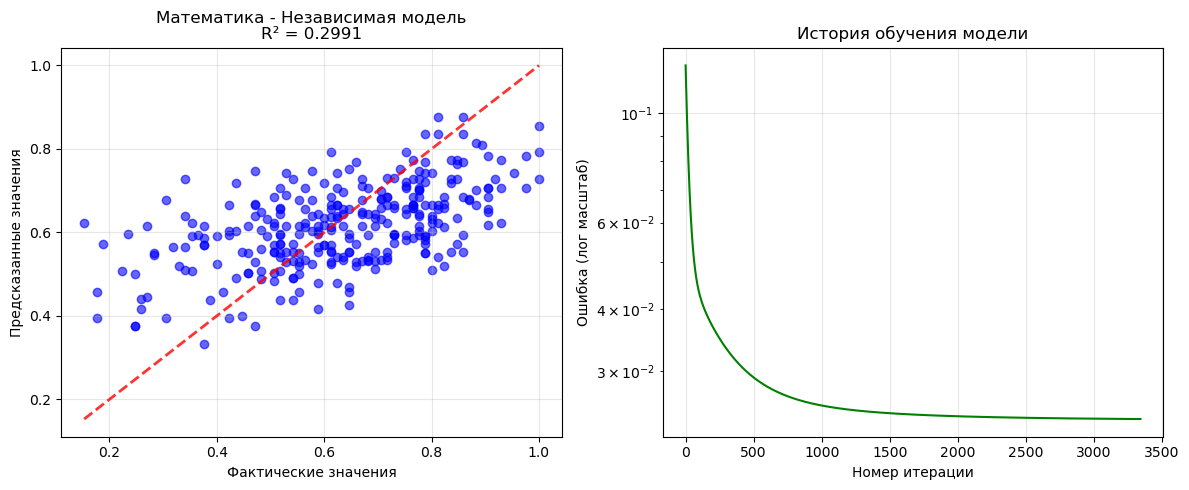


2. МОДЕЛЬ ДЛЯ ЧТЕНИЯ:


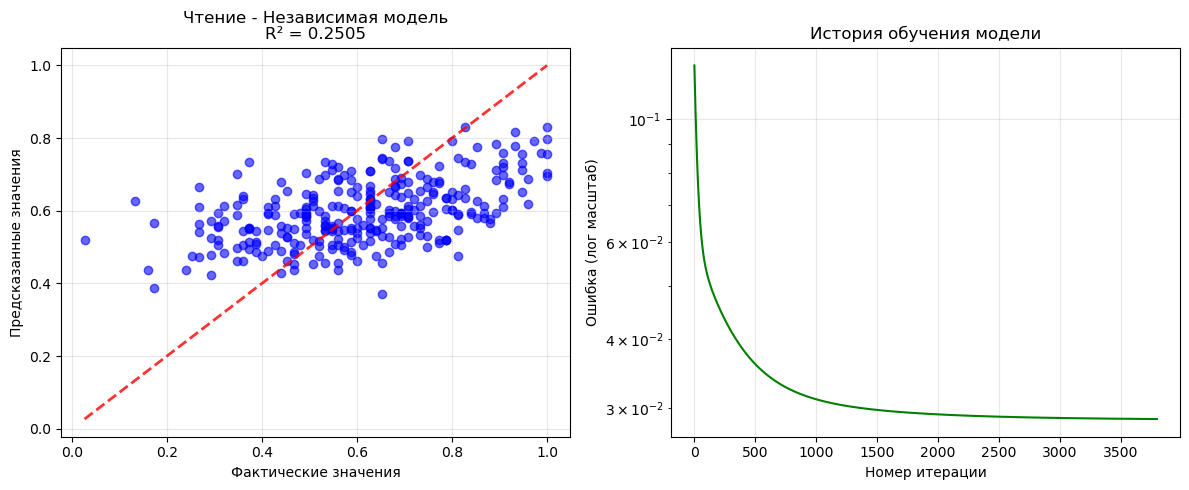


3. МОДЕЛЬ ДЛЯ ПИСЬМА:


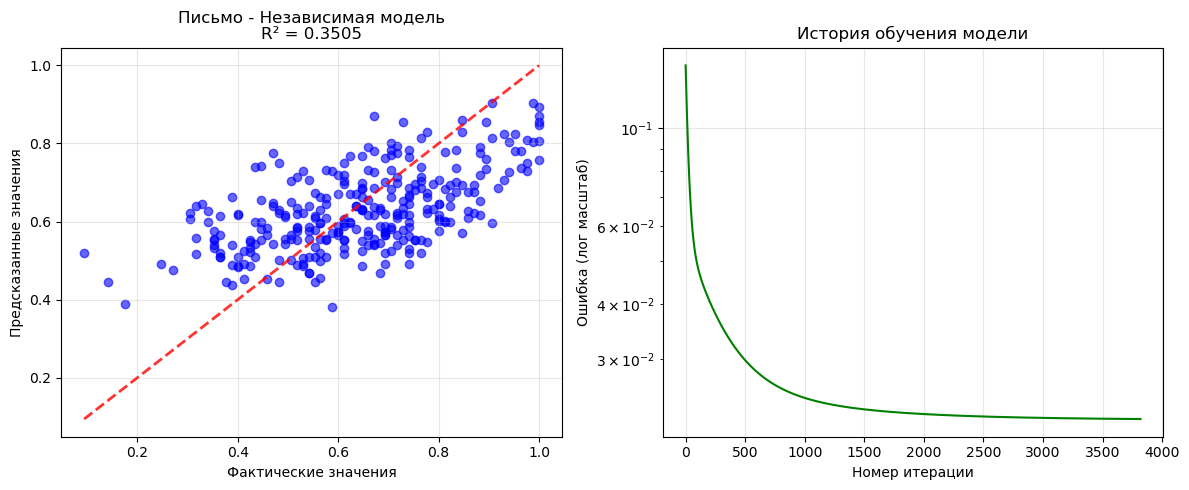


Оценка моделей первого предположения завершена


In [9]:
# =============================================================================
# ОЦЕНКА МОДЕЛЕЙ ПЕРВОГО ПРЕДПОЛОЖЕНИЯ (НЕЗАВИСИМЫЕ ЭКЗАМЕНЫ)
# =============================================================================

print("ОЦЕНКА МОДЕЛЕЙ ПЕРВОГО ПРЕДПОЛОЖЕНИЯ")
print("(экзамены не зависят от результатов уже прошедших экзаменов)")
print("=" * 70)

# Создаем предсказания для тестовой выборки
print("\n1. МОДЕЛЬ ДЛЯ МАТЕМАТИКИ:")
actual_math_1, pred_math_1 = make_predictions(test_data, math_coeffs_1, features_basic, "math")
r2_math_1 = visualize_predictions(actual_math_1, pred_math_1, math_errors_1, "Математика - Независимая модель")

print("\n2. МОДЕЛЬ ДЛЯ ЧТЕНИЯ:")
actual_reading_1, pred_reading_1 = make_predictions(test_data, reading_coeffs_1, features_basic, "reading")
r2_reading_1 = visualize_predictions(actual_reading_1, pred_reading_1, reading_errors_1, "Чтение - Независимая модель")

print("\n3. МОДЕЛЬ ДЛЯ ПИСЬМА:")
actual_writing_1, pred_writing_1 = make_predictions(test_data, writing_coeffs_1, features_basic, "writing")
r2_writing_1 = visualize_predictions(actual_writing_1, pred_writing_1, writing_errors_1, "Письмо - Независимая модель")

print("\nОценка моделей первого предположения завершена")

ОЦЕНКА МОДЕЛЕЙ ВТОРОГО ПРЕДПОЛОЖЕНИЯ
(экзамены зависят от результатов уже прошедших экзаменов)

1. МОДЕЛЬ ДЛЯ МАТЕМАТИКИ:


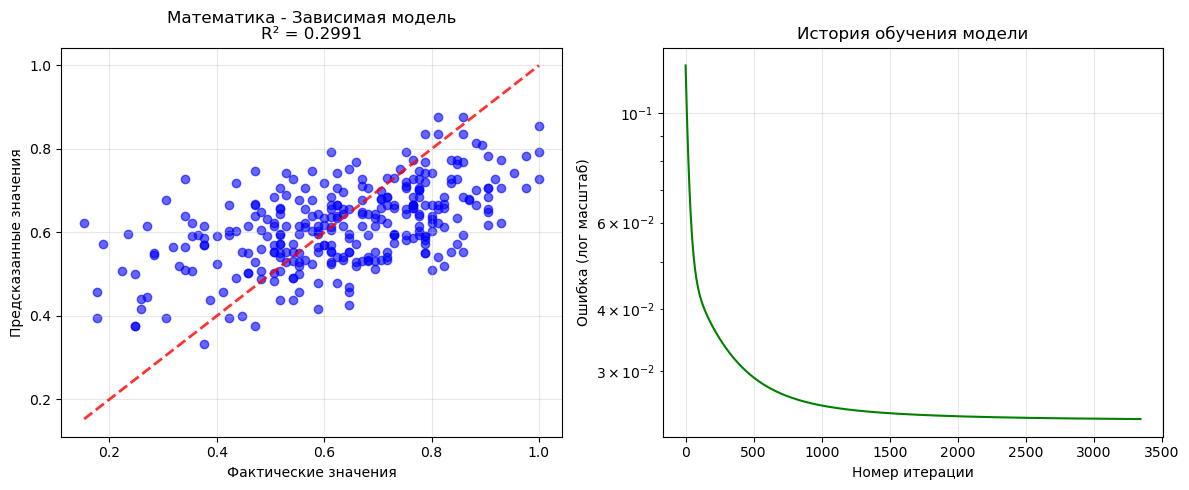


2. МОДЕЛЬ ДЛЯ ЧТЕНИЯ:


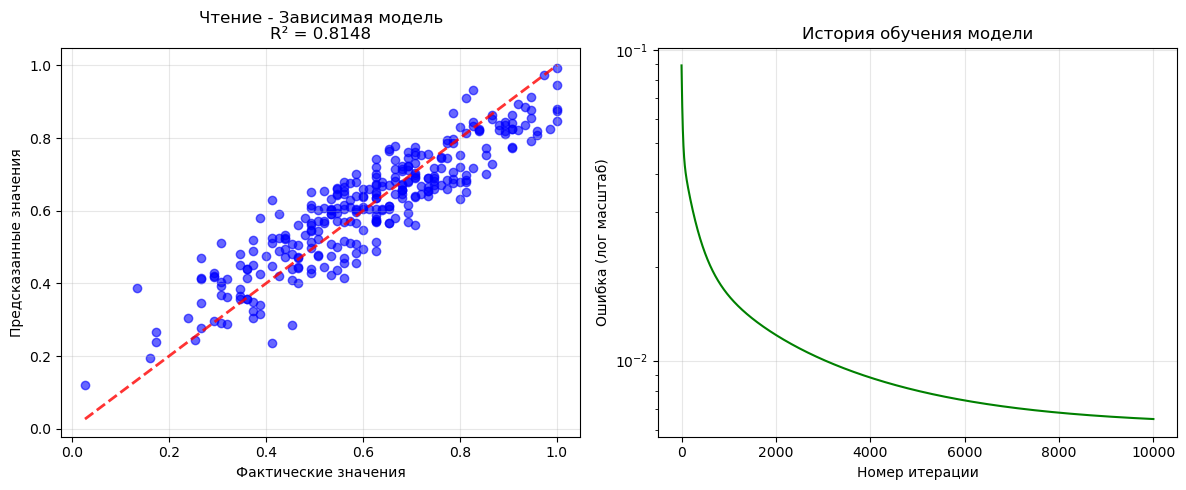


3. МОДЕЛЬ ДЛЯ ПИСЬМА:


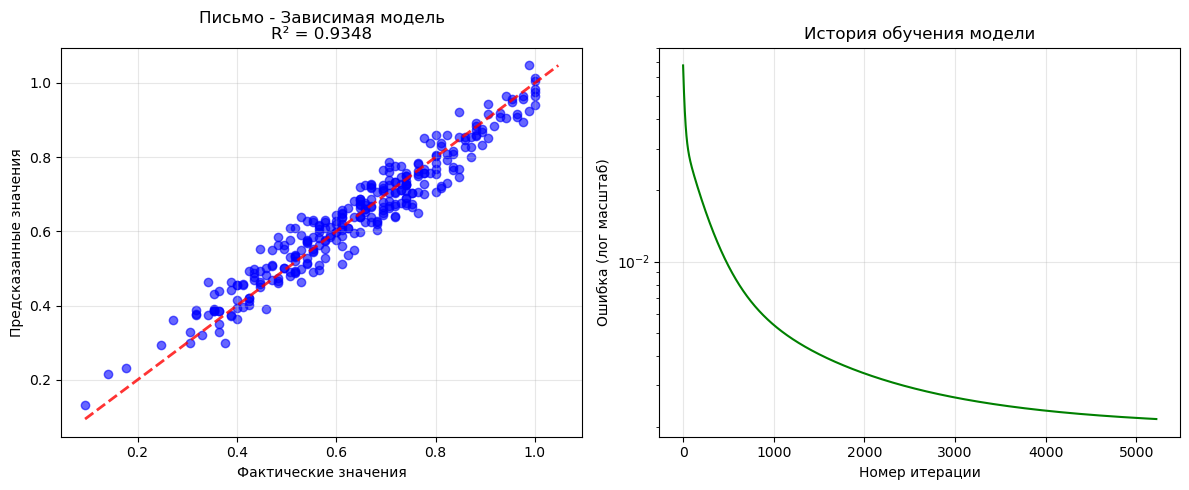


Оценка моделей второго предположения завершена


In [10]:
# =============================================================================
# ОЦЕНКА МОДЕЛЕЙ ВТОРОГО ПРЕДПОЛОЖЕНИЯ (ЗАВИСИМЫЕ ЭКЗАМЕНЫ)
# =============================================================================

print("ОЦЕНКА МОДЕЛЕЙ ВТОРОГО ПРЕДПОЛОЖЕНИЯ")
print("(экзамены зависят от результатов уже прошедших экзаменов)")
print("=" * 70)

# Создаем предсказания для тестовой выборки
print("\n1. МОДЕЛЬ ДЛЯ МАТЕМАТИКИ:")
actual_math_2, pred_math_2 = make_predictions(test_data, math_coeffs_2, features_basic, "math")
r2_math_2 = visualize_predictions(actual_math_2, pred_math_2, math_errors_2, "Математика - Зависимая модель")

print("\n2. МОДЕЛЬ ДЛЯ ЧТЕНИЯ:")
actual_reading_2, pred_reading_2 = make_predictions(test_data, reading_coeffs_2, features_with_math, "reading")
r2_reading_2 = visualize_predictions(actual_reading_2, pred_reading_2, reading_errors_2, "Чтение - Зависимая модель")

print("\n3. МОДЕЛЬ ДЛЯ ПИСЬМА:")
actual_writing_2, pred_writing_2 = make_predictions(test_data, writing_coeffs_2, features_with_math_reading, "writing")
r2_writing_2 = visualize_predictions(actual_writing_2, pred_writing_2, writing_errors_2, "Письмо - Зависимая модель")

print("\nОценка моделей второго предположения завершена")

In [11]:
# =============================================================================
# СРАВНИТЕЛЬНАЯ ТАБЛИЦА R-КВАДРАТ
# =============================================================================

print("СРАВНИТЕЛЬНАЯ ТАБЛИЦА КОЭФФИЦИЕНТОВ ДЕТЕРМИНАЦИИ R²")
print("=" * 70)

# Создаем сводную таблицу результатов
print(f"{'МОДЕЛЬ':<30} {'НЕЗАВИСИМАЯ':<12} {'ЗАВИСИМАЯ':<12} {'ИЗМЕНЕНИЕ':<12}")
print("-" * 70)

# Математика
change_math = r2_math_2 - r2_math_1
print(f"{'Математика':<30} {r2_math_1:<12.4f} {r2_math_2:<12.4f} {change_math:+.4f}")

# Чтение
change_reading = r2_reading_2 - r2_reading_1
print(f"{'Чтение':<30} {r2_reading_1:<12.4f} {r2_reading_2:<12.4f} {change_reading:+.4f}")

# Письмо
change_writing = r2_writing_2 - r2_writing_1
print(f"{'Письмо':<30} {r2_writing_1:<12.4f} {r2_writing_2:<12.4f} {change_writing:+.4f}")

print("-" * 70)

# Вычисляем средние значения
avg_independent = (r2_math_1 + r2_reading_1 + r2_writing_1) / 3
avg_dependent = (r2_math_2 + r2_reading_2 + r2_writing_2) / 3
avg_change = avg_dependent - avg_independent

print(f"{'СРЕДНЕЕ':<30} {avg_independent:<12.4f} {avg_dependent:<12.4f} {avg_change:+.4f}")

print("\nПримечание:")
print("R² = 1.0 - идеальное предсказание")
print("R² = 0.0 - модель не лучше среднего")
print("R² < 0.0 - модель хуже среднего")

СРАВНИТЕЛЬНАЯ ТАБЛИЦА КОЭФФИЦИЕНТОВ ДЕТЕРМИНАЦИИ R²
МОДЕЛЬ                         НЕЗАВИСИМАЯ  ЗАВИСИМАЯ    ИЗМЕНЕНИЕ   
----------------------------------------------------------------------
Математика                     0.2991       0.2991       +0.0000
Чтение                         0.2505       0.8148       +0.5642
Письмо                         0.3505       0.9348       +0.5843
----------------------------------------------------------------------
СРЕДНЕЕ                        0.3001       0.6829       +0.3828

Примечание:
R² = 1.0 - идеальное предсказание
R² = 0.0 - модель не лучше среднего
R² < 0.0 - модель хуже среднего


In [13]:
# =============================================================================
# АНАЛИЗ РЕЗУЛЬТАТОВ И ВЫВОДЫ
# =============================================================================

print("АНАЛИЗ РЕЗУЛЬТАТОВ И ВЫВОДЫ")
print("=" * 70)

print("\n1. АНАЛИЗ РЕЗУЛЬТАТОВ ПО ЭКЗАМЕНАМ:")

print("\n   МАТЕМАТИКА:")
print(f"   - Независимая модель: R² = {r2_math_1:.4f}")
print(f"   - Зависимая модель: R² = {r2_math_2:.4f}")
if abs(r2_math_1 - r2_math_2) < 0.01:
    print("   → Качество моделей практически одинаковое")
    print("   → Это ожидаемо, так как математика - первый экзамен")

print("\n   ЧТЕНИЕ:")
print(f"   - Независимая модель: R² = {r2_reading_1:.4f}") 
print(f"   - Зависимая модель: R² = {r2_reading_2:.4f}")
if r2_reading_2 > r2_reading_1:
    improvement = ((r2_reading_2 - r2_reading_1) / r2_reading_1) * 100
    print(f"   → Зависимая модель улучшила предсказание на {improvement:.1f}%")
    print("   → Учет результата по математике помогает предсказать чтение")

print("\n   ПИСЬМО:")
print(f"   - Независимая модель: R² = {r2_writing_1:.4f}")
print(f"   - Зависимая модель: R² = {r2_writing_2:.4f}")
if r2_writing_2 > r2_writing_1:
    improvement = ((r2_writing_2 - r2_writing_1) / r2_writing_1) * 100
    print(f"   → Зависимая модель улучшила предсказание на {improvement:.1f}%")
    print("   → Учет результатов по математике и чтению значительно улучшает предсказание письма")

print("\n2. ОБЩИЕ ВЫВОДЫ:")
print("   - Для математики оба подхода дают схожие результаты")
print("   - Для чтения и письма зависимые модели показывают лучшее качество")
print("   - Результаты предыдущих экзаменов действительно влияют на результаты последующих")
print("   - Наибольшее улучшение наблюдается для письма, что логично - оно зависит")
print("     от двух предыдущих экзаменов (математики и чтения)")

print("\n3. КАЧЕСТВО МОДЕЛЕЙ В ЦЕЛОМ:")
print(f"   - Средний R² независимых моделей: {avg_independent:.4f}")
print(f"   - Средний R² зависимых моделей: {avg_dependent:.4f}")
print(f"   - Общее улучшение: {avg_change:+.4f} ({avg_change/avg_independent*100:.1f}%)")

if avg_dependent > avg_independent:
    print("   → Зависимые модели в среднем лучше независимых")
else:
    print("   → Независимые модели в среднем лучше зависимых")

АНАЛИЗ РЕЗУЛЬТАТОВ И ВЫВОДЫ

1. АНАЛИЗ РЕЗУЛЬТАТОВ ПО ЭКЗАМЕНАМ:

   МАТЕМАТИКА:
   - Независимая модель: R² = 0.2991
   - Зависимая модель: R² = 0.2991
   → Качество моделей практически одинаковое
   → Это ожидаемо, так как математика - первый экзамен

   ЧТЕНИЕ:
   - Независимая модель: R² = 0.2505
   - Зависимая модель: R² = 0.8148
   → Зависимая модель улучшила предсказание на 225.2%
   → Учет результата по математике помогает предсказать чтение

   ПИСЬМО:
   - Независимая модель: R² = 0.3505
   - Зависимая модель: R² = 0.9348
   → Зависимая модель улучшила предсказание на 166.7%
   → Учет результатов по математике и чтению значительно улучшает предсказание письма

2. ОБЩИЕ ВЫВОДЫ:
   - Для математики оба подхода дают схожие результаты
   - Для чтения и письма зависимые модели показывают лучшее качество
   - Результаты предыдущих экзаменов действительно влияют на результаты последующих
   - Наибольшее улучшение наблюдается для письма, что логично - оно зависит
     от двух предыду